NMFk: Extraction of signals (features/plumes) from observation points (wells) 
===
Case: Concentration Dataset
---

Let us assume that there are multiple wells (monitoring points) detecting simultaneously multiple signals (here, contaminant plumes with different chemical signatures).
Our goal is to estimate automatically the number of signals (plumes) using unsupervised machine learning (ML)
Here, we apply our method called **NMFk** which uses NMF coupled with k-means clustering.
For more information about **NMFk** and our unsupervised ML methods in general check  http://tensors.lanl.gov.

In the example presented here, we assume that there are 20 wells (monitoring points), 2 sources (contaminant plumes), and 3 chemical species (e.g., nitrate, sulfate, chloride) detected at each well.

These types of unsupervised machine learning analyses are applicable in many other situations where the mixing of signals (volumes/mass) is constrained by volumetric or weight constraints.
For example, these types of problems occur in the case of mass transport in fluids (e.g., atmosphere, oceans, watersheds, oil/gas/geothermal reservoirs, aquifers, etc.).

In [1]:
import NMFk
import Random

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7699312663131102596\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-999901515176782948\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7699312663131102596\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/monty/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/monty/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
nWells = 20
nSources = 2
nSpecies = 3
Random.seed!(2015);

Due to volumetric constraints, mixing coefficients of the different sources (plumes) at each of well (observation point) have to add to 1.

The mixing matrix `W` is defined as:

In [3]:
W = rand(nWells, nSources)
for i = 1:nWells
	W[i, :] ./= sum(W[i, :])
end
display(W)

20×2 Array{Float64,2}:
 0.395136  0.604864
 0.231592  0.768408
 0.351722  0.648278
 0.562318  0.437682
 0.476007  0.523993
 0.547533  0.452467
 0.446452  0.553548
 0.499894  0.500106
 0.601403  0.398597
 0.267675  0.732325
 0.592915  0.407085
 0.55854   0.44146 
 0.735353  0.264647
 0.364806  0.635194
 0.121244  0.878756
 0.788195  0.211805
 0.245554  0.754446
 0.818814  0.181186
 0.450388  0.549612
 0.507392  0.492608

Here, `W` defines 2 mixing values for each of the 20 observation points.

The 2 mixing values define how the 2 sources (signals) are mixed at each well.

The mixing values for each well (along each row) add up to 1.

Let us also define `H` as a matrix which specifies the concentrations of the 3 chemical species present in the 2 contaminant sources:

In [6]:
H = [100 0 3; 5 10 20]

2×3 Array{Int64,2}:
 100   0   3
   5  10  20

Here, the first source (row 1) has elevated concentration for the first chemical component (100).

The second source (row 2) has elevated concentrations for the second (10) and third (20) chemical species.

Now for this synthetic problem, we can compute the synthetic observed concentrations at each the wells `X` as:

In [7]:
X = W * H

20×3 Array{Float64,2}:
 42.5379  6.04864  13.2827 
 27.0013  7.68408  16.0629 
 38.4136  6.48278  14.0207 
 58.4202  4.37682  10.4406 
 50.2206  5.23993  11.9079 
 57.0156  4.52467  10.6919 
 47.413   5.53548  12.4103 
 52.4899  5.00106  11.5018 
 62.1333  3.98597   9.77616
 30.4291  7.32325  15.4495 
 61.3269  4.07085   9.92044
 58.0613  4.4146   10.5048 
 74.8585  2.64647   7.49901
 39.6565  6.35194  13.7983 
 16.5182  8.78756  17.9389 
 79.8785  2.11805   6.60068
 28.3277  7.54446  15.8256 
 82.7873  1.81186   6.08016
 47.7869  5.49612  12.3434 
 53.2022  4.92608  11.3743 

We can also make some of the observations ''missing'' by setting respective matrix entries equal to **NaN**:

In [8]:
X[1, 1] = NaN
display(X)

20×3 Array{Float64,2}:
 NaN       6.04864  13.2827 
  27.0013  7.68408  16.0629 
  38.4136  6.48278  14.0207 
  58.4202  4.37682  10.4406 
  50.2206  5.23993  11.9079 
  57.0156  4.52467  10.6919 
  47.413   5.53548  12.4103 
  52.4899  5.00106  11.5018 
  62.1333  3.98597   9.77616
  30.4291  7.32325  15.4495 
  61.3269  4.07085   9.92044
  58.0613  4.4146   10.5048 
  74.8585  2.64647   7.49901
  39.6565  6.35194  13.7983 
  16.5182  8.78756  17.9389 
  79.8785  2.11805   6.60068
  28.3277  7.54446  15.8256 
  82.7873  1.81186   6.08016
  47.7869  5.49612  12.3434 
  53.2022  4.92608  11.3743 

Now assuming that only `X` is **known**, **NMFk** can estimate **unknown** `W` and `H`.

**NMFk** estimates *automatically* the number signals (features; here, contaminant sources) present in the analyzed dataset `X`.

The number of signals is equal to the number of columns in `W` and the number of rows in `H`.

**NMFk** computes the number signals (features) based on silhouettes of the k-means clusters obtained from a series of **NMF** solutions using random initial guesses (see the papers and presentations at http://tensors.lanl.gov for more details).

**NMFk** execution produces:

In [9]:
We, He, fit, sil, aic, kopt = NMFk.execute(X, 2:10; mixture=:mixmatch);

┌ Info: Saving requested but casefilename not specified; casefilename = "nmfk" will be used!
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:32



OF: min 4.7198094793251044e-17 max 1.6465787849872077e-16 mean 8.306355188793821e-17 std 3.877523176667068e-17
Worst correlation by columns: 24.25443447350524
Worst correlation by rows: 3.423472891006975
Worst norm by columns: 1.4078721785180554e-11
Worst norm by rows: 2.650786898914382e-11
Signals:  2 Fit:     12.20422 Silhouette:    0.9983215 AIC:    -40.96958


┌ Info: Saving requested but casefilename not specified; casefilename = "nmfk" will be used!
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:32



OF: min 9.669055104621031e-17 max 1.6129725483140186e-14 mean 2.5333881794448646e-15 std 5.03244164533123e-15
Worst correlation by columns: 24.254434475147093
Worst correlation by rows: 3.4234728905820844
Worst norm by columns: 2.6240932686909024e-11
Worst norm by rows: 3.066852340964931e-11
Signals:  3 Fit:     226.3254 Silhouette:   -0.2649711 AIC:     177.3217


┌ Info: Saving requested but casefilename not specified; casefilename = "nmfk" will be used!
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:32



OF: min 2.222688145655218e-16 max 8.149071329880585e-14 mean 1.81573428733396e-14 std 2.8912947528325675e-14
Worst correlation by columns: 24.254434465132285
Worst correlation by rows: 3.4234728942268418
Worst norm by columns: 4.788205412253758e-11
Worst norm by rows: 4.3083159013292666e-11
Signals:  4 Fit:     311.6967 Silhouette:    -0.218569 AIC:     242.2051


┌ Info: Saving requested but casefilename not specified; casefilename = "nmfk" will be used!
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:32



OF: min 2.0865483858521294e-16 max 1.6885450845322277e-14 mean 4.026471390747544e-15 std 5.171338390891573e-15
Worst correlation by columns: 24.25443446514534
Worst correlation by rows: 3.423472890096886
Worst norm by columns: 4.7236900232388383e-11
Worst norm by rows: 5.598852104856424e-11
Signals:  5 Fit:     170.9709 Silhouette:   -0.2012058 AIC:     252.7734


┌ Info: Saving requested but casefilename not specified; casefilename = "nmfk" will be used!
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:32



OF: min 1.4174255064589598e-16 max 7.868719884820144e-14 mean 1.082942515339706e-14 std 2.402425702098544e-14
Worst correlation by columns: 24.254434469204305
Worst correlation by rows: 3.42347289206934
Worst norm by columns: 3.749523745740863e-11
Worst norm by rows: 4.130439216187876e-11
Signals:  6 Fit:     1405.182 Silhouette:   -0.4183919 AIC:     423.0527


┌ Info: Saving requested but casefilename not specified; casefilename = "nmfk" will be used!
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:32



OF: min 6.348874702734478e-16 max 1.1353478005590746e-13 mean 1.6310742928232433e-14 std 3.500973543617213e-14
Worst correlation by columns: 24.254434468958106
Worst correlation by rows: 3.4234728873142712
Worst norm by columns: 7.726644714155334e-11
Worst norm by rows: 9.572157473598802e-11
Signals:  7 Fit:     2138.874 Silhouette:    -0.412846 AIC:     493.8393


┌ Info: Saving requested but casefilename not specified; casefilename = "nmfk" will be used!
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:32



OF: min 4.5460256867435374e-15 max 3.6194380384475465e-14 mean 1.2155755184994836e-14 std 9.537585056291363e-15
Worst correlation by columns: 24.25443446281948
Worst correlation by rows: 3.4234728766076854
Worst norm by columns: 2.345196439266021e-10
Worst norm by rows: 2.707909192255653e-10
Signals:  8 Fit:     612.8291 Silhouette:   -0.6611032 AIC:     466.0924


┌ Info: Saving requested but casefilename not specified; casefilename = "nmfk" will be used!
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:32



OF: min 8.936231841753186e-16 max 4.7181245821629244e-14 mean 1.0863061425953257e-14 std 1.336505501310279e-14
Worst correlation by columns: 24.25443447026324
Worst correlation by rows: 3.4234728875212226
Worst norm by columns: 1.1417914284797606e-10
Worst norm by rows: 1.204339875688689e-10
Signals:  9 Fit:     2361.796 Silhouette:   -0.5681798 AIC:     591.6888


┌ Info: Saving requested but casefilename not specified; casefilename = "nmfk" will be used!
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:32



OF: min 1.7409101055687217e-15 max 2.5075396908200857e-14 mean 1.2620242072039992e-14 std 6.515506277918824e-15
Worst correlation by columns: 24.254434469984375
Worst correlation by rows: 3.4234728844899296
Worst norm by columns: 1.4272904552399244e-10
Worst norm by rows: 1.5767995419372723e-10
Signals: 10 Fit:     4288.208 Silhouette:   -0.4725063 AIC:     672.8791
Signals:  2 Fit:     12.20422 Silhouette:    0.9983215 AIC:    -40.96958
Signals:  3 Fit:     226.3254 Silhouette:   -0.2649711 AIC:     177.3217
Signals:  4 Fit:     311.6967 Silhouette:    -0.218569 AIC:     242.2051
Signals:  5 Fit:     170.9709 Silhouette:   -0.2012058 AIC:     252.7734
Signals:  6 Fit:     1405.182 Silhouette:   -0.4183919 AIC:     423.0527
Signals:  7 Fit:     2138.874 Silhouette:    -0.412846 AIC:     493.8393
Signals:  8 Fit:     612.8291 Silhouette:   -0.6611032 AIC:     466.0924
Signals:  9 Fit:     2361.796 Silhouette:   -0.5681798 AIC:     591.6888
Signals: 10 Fit:     4288.208 Silhouette:   -0

┌ Info: Results
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:19
┌ Info: Optimal solution: 2 signals
└ @ NMFk /Users/monty/.julia/dev/NMFk/src/NMFkExecute.jl:25


Above, **NMFk** provides estimates of `W` and `H` (`We` and `He`).
These are vectors of matrices for a different number of sources. For example, `We[2]`, `We[3]`, ..., `He[2]`, `He[3]`, ... .

The **NMFk** analyses are performed for the number of sources varying between 2 and 10 (`2:10`).

**NMFk** also returns the reconstruction error (`fit`); here, `fit` is a Frobenius norm between the **known** `X` and estimated `Xe` where `Xe` is computed as, for example, `We[2] * He[2]`.

**NMFk** also provides the silhouettes of the k-means clusters (`sil`)

`fit` and `sil` are vectors with estimates for a different number of sources.

The automatically estimated number of features (plumes) `kopt` is returned as well.

In the example above, `kopt` is equal to 2 which matches the **true** **unknown** number of sources.

The estimated concentrations of the 3 sources are:

In [11]:
He[2]

2×3 Array{Float64,2}:
 89.9535   1.05752   4.79779
  8.68881  9.6117   19.3399 

The concentration estimates are very close to the actual values `H`:

In [12]:
H

2×3 Array{Int64,2}:
 100   0   3
   5  10  20

The estimated mixing coefficient at the 20 wells are:

In [13]:
We[2]

20×2 Array{Float64,2}:
 0.417606  0.582394
 0.234504  0.765496
 0.369     0.631   
 0.60478   0.39522 
 0.508147  0.491853
 0.588226  0.411774
 0.475058  0.524942
 0.53489   0.46511 
 0.648539  0.351461
 0.274902  0.725098
 0.639036  0.360964
 0.600551  0.399449
 0.798507  0.201493
 0.383648  0.616352
 0.11096   0.88904 
 0.857669  0.142331
 0.250136  0.749864
 0.891949  0.108051
 0.479465  0.520535
 0.543285  0.456715

They are also very close to the actual values:

In [14]:
W

20×2 Array{Float64,2}:
 0.395136  0.604864
 0.231592  0.768408
 0.351722  0.648278
 0.562318  0.437682
 0.476007  0.523993
 0.547533  0.452467
 0.446452  0.553548
 0.499894  0.500106
 0.601403  0.398597
 0.267675  0.732325
 0.592915  0.407085
 0.55854   0.44146 
 0.735353  0.264647
 0.364806  0.635194
 0.121244  0.878756
 0.788195  0.211805
 0.245554  0.754446
 0.818814  0.181186
 0.450388  0.549612
 0.507392  0.492608

These matrices can be also easily ploted:

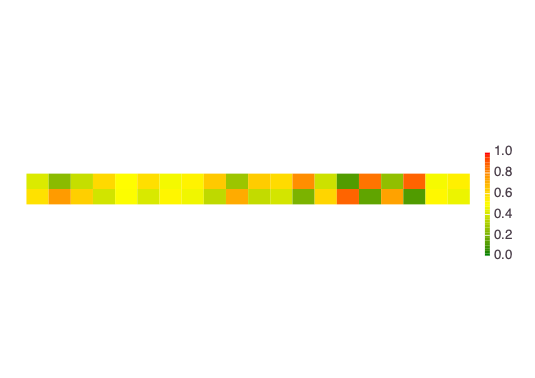

In [17]:
display(NMFk.plotmatrix(We[2]'))

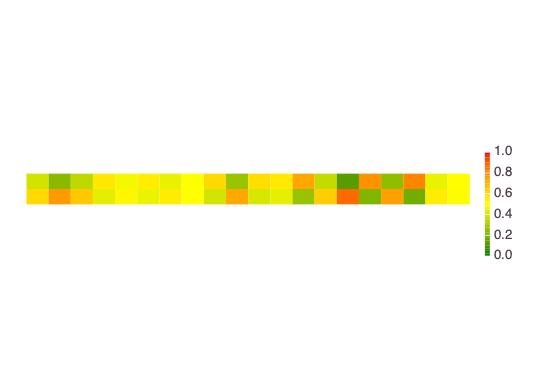

In [18]:
display(NMFk.plotmatrix(W'))

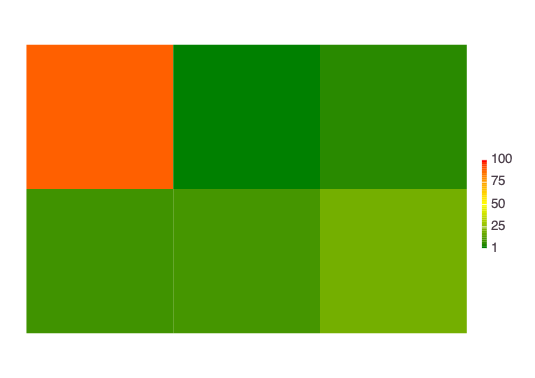

In [19]:
display(NMFk.plotmatrix(He[2]))

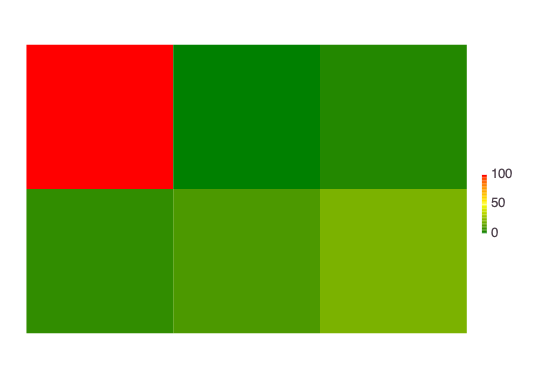

In [20]:
display(NMFk.plotmatrix(H))

In conclusion, **NMFk** successful estimated the number of plumes, the original concentrations at the contaminant sources (before mixing in the aquifer), and the mixing coefficients at each well.

The **NMFk** unsupervised ML analyses are unbiased and robust.